# 把照片转换成圆形马赛克效果

In [4]:
import cv2
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

首先使用`cvtColor()`将图像转换为灰度图像，然后使用`Canny()`找出图像的边缘。

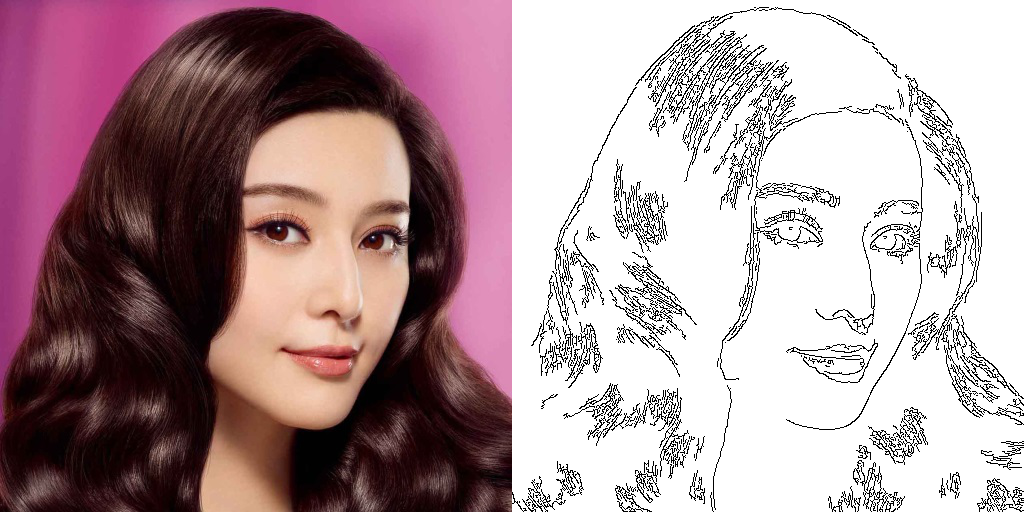

In [5]:
img = cv2.imread("beauty05.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
edges = 255 - cv2.Canny(img_gray, 50, 200)
Image.fromarray(np.hstack((img, edges[:, :, None].repeat(3, axis=2))))

非边缘部分可以用大圆填充。用`distanceTransform()`找到每个白色像素到最近的黑色像素的距离。

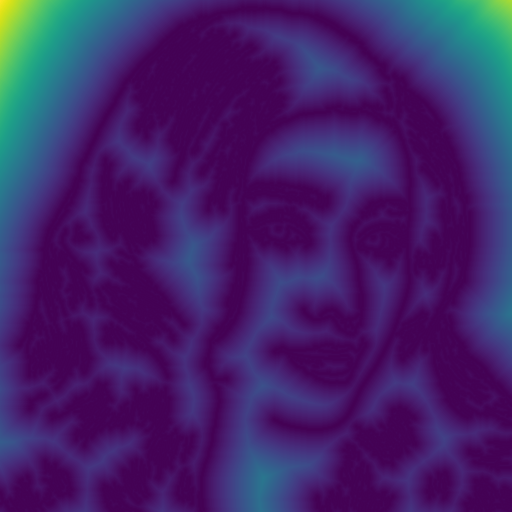

In [6]:
from matplotlib.pyplot import get_cmap
dist = cv2.distanceTransform(edges, cv2.DIST_L2, 3)
cmap = get_cmap("viridis")
Image.fromarray(cmap(dist / dist.max(), bytes=True))

所有距离中的最大值就是能填充的最大的圆。找到这个最大可填充圆的圆心`(cx, cy)`和半径`radius`。

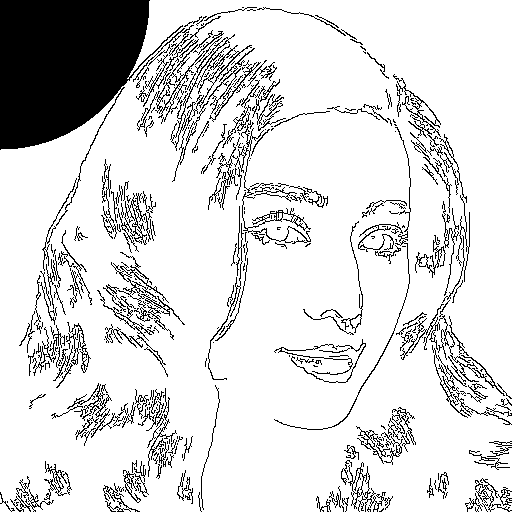

In [7]:
idx = np.argmax(dist)
cy, cx = np.unravel_index(idx, dist.shape)
radius = dist[cy, cx]
cv2.circle(edges, (cx, cy), radius, (0, 0, 0, 0), thickness=-1)
Image.fromarray(edges)

下面的`find_circiles(filename, n)`将图像文件`filename`转换为`n`个圆形填充图案。

❶当找到`n//2`个圆形之后，将开始找到的边缘图案`edges_original`设置为白色，这样可以继续让圆形填充边缘部分。❷为了找到每个圆形对应的颜色，需要找到圆形中每个像素的坐标，然后计算原始图像中这些坐标的像素的颜色平均值。这里通过比较`cv2.circle()`绘制圆形前后的像素值的差别，找到这些坐标。

In [16]:
def find_circles(filename, n):
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    edges = 255 - cv2.Canny(img_gray, 50, 200)
    edges_original = edges.copy()
    circles = []
    for i in range(n):
        if i == n // 2:
            edges[edges_original == 0] = 255    #❶
        dist = cv2.distanceTransform(edges, cv2.DIST_L2, 3)
        idx = np.argmax(dist)
        cy, cx = map(int, np.unravel_index(idx, dist.shape))
        radius = int(round(dist[cy, cx]))
        edges_old = edges.copy()
        cv2.circle(edges, (cx, cy), radius, (0, 0, 0, 0), thickness=-1)
        color = img[edges_old != edges].mean(0).astype(np.uint8) #❷
        circles.append([cx, cy, radius] + color.tolist())
    return dict(width=img.shape[1], height=img.shape[0], circles=circles)

In [17]:
circles = find_circles("beauty05.jpg", 1500)

下面使用JavaScript的Raphael绘图库绘制圆形：

In [18]:
import embedjs
embedjs.embed_resources("raphael")

In [19]:
def draw_circles_js(uid, parameter):
    cellwidth = 10
    width = parameter.width
    height = parameter.height

    def draw(Raphael):
        paper = Raphael(uid, width, height)
        for i, circle in enumerate(parameter.circles):
            x, y, radius, r, g, b =  circle
            c = paper.circle(x, y, radius)
            c.attr({"fill": Raphael.rgb(r, g, b), "stroke-width":0})

    require(['raphael'], draw)

def draw_circles(parameter):
    from py2js import py2js_call
    py2js_call(draw_circles_js, parameter)

In [21]:
draw_circles(circles)

## 变形动画

先将所有的图片的圆形信息保存到JSON文件之中。

In [10]:
from glob import glob
import json

In [25]:
for fn in glob("beauty*.jpg"):
    circles = find_circles(fn, 1500)
    with open(fn.replace(".jpg", ".json"), "w") as f:
        json.dump(circles, f)

下面使用Bokeh绘制动画，为了保证动画流畅，使用`webgl`绘制圆形。`output_notebook()`缺省不载入`bokeh-gl`库，需要我们手工创建`Resources`对象指定载入的模块。

In [46]:
from bokeh.io import output_notebook, show
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure
from bokeh.models.callbacks import CustomJS
from bokeh.resources import Resources
output_notebook(Resources(mode="cdn", components=["bokeh", "bokeh-gl"]))

Loading BokehJS ...

In [47]:
data = []
for fn in glob("*.json"):
    with open(fn) as f:
        data.append(json.load(f))

circle_source = ColumnDataSource(data={"x":[], "y":[], "r":[], "color":[]})
data_source = ColumnDataSource(data={"images":data})

fig = figure(output_backend="webgl", tools="", toolbar_location=None,
              x_range=(0, 500), y_range=(0, 500),
              x_axis_type=None, y_axis_type=None,
              plot_width=500, plot_height=500,
              min_border_left=0, min_border_right=0, min_border_bottom=0, min_border_top=0)

def animate(circle_source=circle_source, data_source=data_source):
    frame = 0
    total_frame = 200
    images = data_source.data.images
    current_image = 0
    
    def rgb(red, green, blue):
        color = 0x1000000+ (blue | 0) + 0x100 * (green | 0) + 0x10000 * (red | 0)
        return '#' + color.toString(16).substr(1)
    
    def load_frame(frame):
        next_image = (current_image + 1) % len(images)
        k = frame / total_frame * 2
        if k > 1:
            k = 1
        circle_source.data.x = x = []
        circle_source.data.y = y = []
        circle_source.data.r = r = []
        circle_source.data.color = color = []
        
        for i, c1 in enumerate(images[current_image].circles):
            c2 = images[next_image].circles[i]
            x1, y1, radius1, r1, g1, b1 = c1
            x2, y2, radius2, r2, g2, b2 = c2
            x.append(x1 + (x2 - x1) * k)
            y.append(500 - (y1 + (y2 - y1) * k))
            r.append(radius1 + (radius2 - radius1) * k)
            color.append(rgb(r1 + (r2 - r1) * k, g1 + (g2 - g1) * k, b1 + (b2 - b1) * k))
            
        circle_source.change.emit()
    
    def start():
        nonlocal frame, current_image
        load_frame(frame)
        frame += 1    
        if frame == total_frame:
            frame = 0
            current_image = (current_image + 1) % len(images)
            
    tid = window.setInterval(start, 20)
    
fig.circle(x="x", y="y", radius="r", fill_color="color", line_width=0, line_color=None, source=circle_source)
cjs = CustomJS.from_py_func(animate)

fig.js_on_change("inner_width", CustomJS.from_py_func(animate))
show(fig)